<a href="https://colab.research.google.com/github/uruba24/Pneumonia-Detection-from-Chest-X-ray/blob/main/Pneumonia_Detection_from_Chest_X_ray_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()  # Upload the kaggle.json file

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"uroobaaftab","key":"e6d98caa38deaeeffece24c09cbd493f"}'}

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model


In [ ]:
train_dir = "chest_xray/train"
val_dir = "chest_xray/val"
test_dir = "chest_xray/test"


In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1.0/255,      # Normalize pixel values
    rotation_range=20,    # Random rotation
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1.0/255)  # Only rescaling for validation & test

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


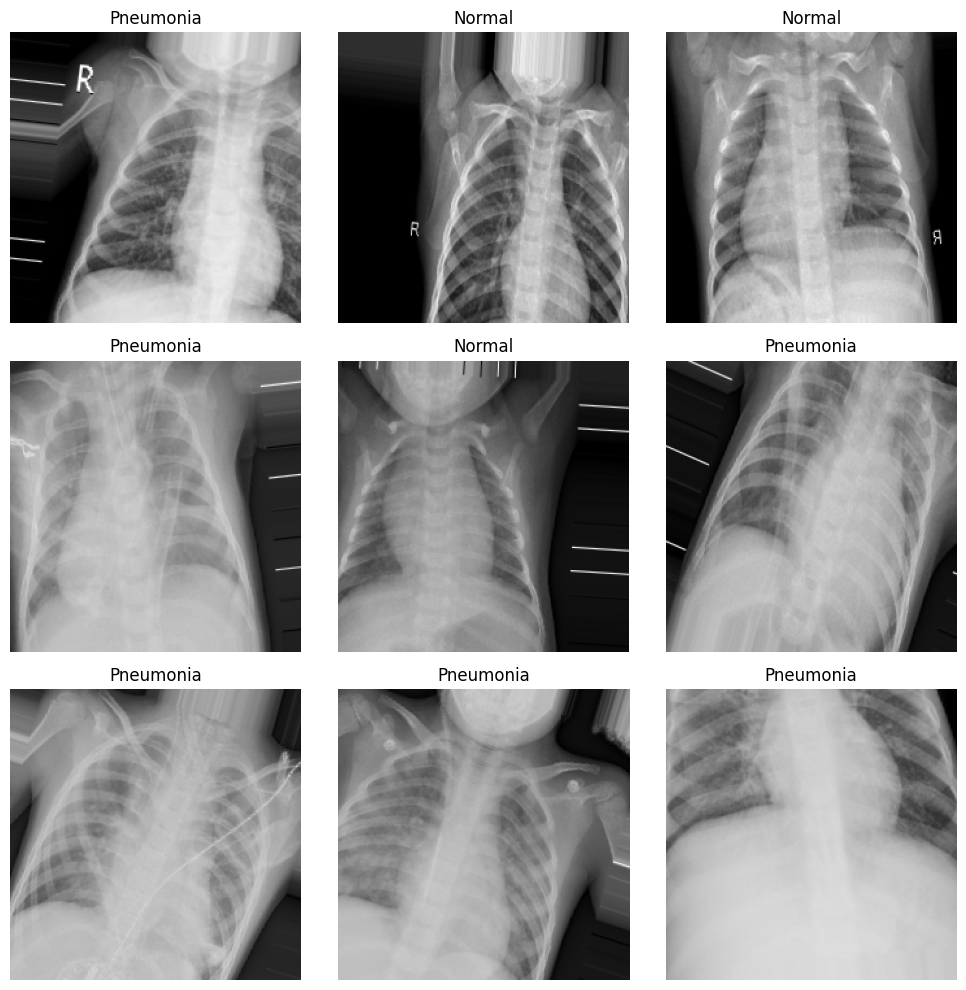

In [ ]:
def plot_images(generator):
    images, labels = next(generator)
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.set_title("Pneumonia" if labels[i] == 1 else "Normal")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

plot_images(train_generator)


In [ ]:
# Load ResNet50 model pre-trained on ImageNet, without the top (fully connected) layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model (no training on these layers)
for layer in base_model.layers:
    layer.trainable = False


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Add custom layers on top
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout to avoid overfitting
x = Dense(1, activation='sigmoid')(x)  # Binary classification (Pneumonia or Normal)

# Define the final model
model = Model(inputs=base_model.input, outputs=x)


In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE
)
model.save("pneumonia_model.h5")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 119s 629ms/step - accuracy: 0.6919 - loss: 2.3143 - val_accuracy: 0.5000 - val_loss: 0.7095
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 129s 600ms/step - accuracy: 0.7290 - loss: 0.6008 - val_accuracy: 0.5000 - val_loss: 0.8998
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 596ms/step - accuracy: 0.7457 - loss: 0.5420 - val_accuracy: 0.5000 - val_loss: 0.6631
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 598ms/step - accuracy: 0.7517 - loss: 0.5188 - val_accuracy: 0.5000 - val_loss: 0.6541
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 593ms/step - accuracy: 0.7394 - loss: 0.5143 - val_accuracy: 0.5000 - val_loss: 0.6608
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 141s 589ms/step - accuracy: 0.7445 - loss: 0.5463 - val_accuracy: 0.5000 - val_loss: 0.7252
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 143s 597ms/step - accuracy: 0.7581 - loss: 0.5909 - val_accuracy: 0.5000 - val_loss: 0.7122
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 591ms/step - accuracy: 0.7425 - los

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 235ms/step - accuracy: 0.6363 - loss: 0.5412
Test Accuracy: 62.66%


In [ ]:
# Unfreeze the last few layers of the ResNet50 model
for layer in base_model.layers[-10:]:  # Unfreeze the last 10 layers
    layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [ ]:
# Continue training with the unfreezed layers
history_finetuned = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=5,  # Fewer epochs for fine-tuning
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE
)


Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 115s 615ms/step - accuracy: 0.7778 - loss: 0.5324 - val_accuracy: 0.5000 - val_loss: 3.3201
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 597ms/step - accuracy: 0.8443 - loss: 0.3331 - val_accuracy: 0.5000 - val_loss: 2.8274
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 589ms/step - accuracy: 0.8724 - loss: 0.2827 - val_accuracy: 0.5625 - val_loss: 1.1339
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 595ms/step - accuracy: 0.8694 - loss: 0.2956 - val_accuracy: 0.6250 - val_loss: 0.8923
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 589ms/step - accuracy: 0.8783 - loss: 0.2673 - val_accuracy: 0.6250 - val_loss: 1.3024


In [ ]:
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss * 100:.2f}%")

19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 246ms/step - accuracy: 0.8209 - loss: 0.4409
Test Accuracy: 81.09%
Test Loss: 48.32%


<ipython-input-25-f0017eff57e8>:38: RuntimeWarning: invalid value encountered in divide
  heatmap /= np.max(heatmap)
<ipython-input-25-f0017eff57e8>:57: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


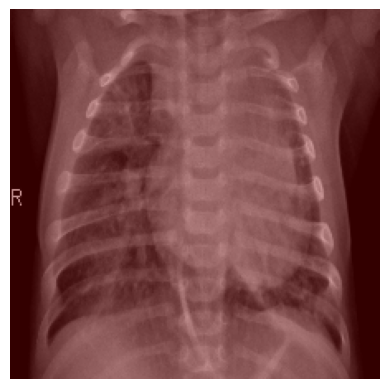

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Function to generate Grad-CAM heatmap
def grad_cam(model, img_array, class_idx):
    # Get the final convolutional layer of the model
    last_conv_layer = model.get_layer("conv5_block3_out")  # For ResNet50, this is the last conv layer

    # Create a model that outputs the last convolutional layer's activations and the final predictions
    grad_model = tf.keras.models.Model(
        inputs=model.input, outputs=[last_conv_layer.output, model.output]
    )

    # Compute the gradient of the class score w.r.t the convolutional layer output
    with tf.GradientTape() as tape:
        last_conv_layer_output, predictions = grad_model(img_array)
        tape.watch(last_conv_layer_output)
        loss = predictions[:, 0]

    # Compute gradients
    grads = tape.gradient(loss, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # Average across width and height

    # Multiply each channel in the convolutional output by the corresponding gradient
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()

    for i in range(last_conv_layer_output.shape[-1]):
        last_conv_layer_output[..., i] *= pooled_grads[i]

    # Average the feature map along the channels dimension to get the heatmap
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # Normalize the heatmap between 0 and 1
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap

# Visualize Grad-CAM on an example image
def display_grad_cam(img_path, model, class_idx):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Generate Grad-CAM heatmap
    heatmap = grad_cam(model, img_array, class_idx)

    # Load the original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))

    # Apply the heatmap to the image
    heatmap = np.uint8(255 * heatmap)
    jet_heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    # Resize jet_heatmap to match the shape of img
    jet_heatmap = cv2.resize(jet_heatmap, (img.shape[1], img.shape[0]))
    superimposed_img = cv2.addWeighted(img, 0.6, jet_heatmap, 0.4, 0)

    # Display the image with heatmap
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

# Example of using Grad-CAM on a test image
img_path = "/content/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg"  # Replace with an actual image path from the test set
display_grad_cam(img_path, model, class_idx=1)  # 1 for Pneumonia, 0 for Normal


In [ ]:
pip install streamlit tensorflow opencv-python matplotlib numpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 83.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 119.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.6 MB/s eta 0:00:00


In [ ]:
%%writefile app.py
import streamlit as st
import numpy as np
import tensorflow as tf
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the trained model
model = load_model("pneumonia_model.h5")  # Ensure this path is correct

# Function to preprocess the uploaded image
def preprocess_image(img):
    img = cv2.resize(img, (224, 224))  # Resize to model input size
    img = img / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Function to generate Grad-CAM heatmap
def grad_cam(model, img_array):
    last_conv_layer = model.get_layer("conv5_block3_out")  # Last conv layer in ResNet50
    grad_model = tf.keras.models.Model(
        inputs=model.input, outputs=[last_conv_layer.output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        loss = predictions[:, 0]  # Assuming binary classification

    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_output = conv_output.numpy()[0]

    for i in range(conv_output.shape[-1]):
        conv_output[..., i] *= pooled_grads[i].numpy()

    heatmap = np.mean(conv_output, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap

# Function to overlay heatmap on image
def overlay_heatmap(img, heatmap):
    heatmap = np.uint8(255 * heatmap)
    jet_heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, jet_heatmap, 0.4, 0)
    return superimposed_img

# Streamlit UI
st.title("Pneumonia Detection from Chest X-rays")
st.write("Upload a chest X-ray image, and the model will predict if it's **Normal** or **Pneumonia**.")

uploaded_file = st.file_uploader("Upload an X-ray Image", type=["jpg", "png", "jpeg"])

if uploaded_file is not None:
    # Convert the uploaded file to an OpenCV image
    file_bytes = np.asarray(bytearray(uploaded_file.read()), dtype=np.uint8)
    img = cv2.imdecode(file_bytes, 1)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Preprocess the image for model prediction
    img_array = preprocess_image(img_rgb)

    # Model prediction
    prediction = model.predict(img_array)
    result = "Pneumonia" if prediction[0][0] > 0.5 else "Normal"
    confidence = prediction[0][0] if result == "Pneumonia" else 1 - prediction[0][0]

    st.image(img_rgb, caption="Uploaded X-ray", use_column_width=True)
    st.write(f"### Prediction: **{result}**")
    st.write(f"Confidence: {confidence:.2%}")

    # Generate and overlay Grad-CAM heatmap
    heatmap = grad_cam(model, img_array)
    heatmap_img = overlay_heatmap(img_rgb, heatmap)

    st.image(heatmap_img, caption="Grad-CAM Heatmap", use_column_width=True)


Writing app.py


In [ ]:
!pip install pyngrok

In [ ]:
from pyngrok import ngrok

# Set your ngrok authtoken
ngrok.set_auth_token("2rRS9CabxcpLQSLlp8q43YVTZck_5Tb8ZycAuMYQ84pwB3eG4")

In [ ]:
# Start Streamlit
!streamlit run app.py &>/dev/null &

# Expose Streamlit via ngrok
public_url = ngrok.connect(addr=8501)
print("Streamlit app is running at:", public_url)


Streamlit app is running at: NgrokTunnel: "https://bbc8-34-16-205-59.ngrok-free.app" -> "http://localhost:8501"
